1.   Initialiseer de nodige python libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix




2.   Genereer afbeeldingen van 50 cirkels en 50 veelhoeken, sla ze elk op in  een map.


In [2]:

# Create directories for images
os.makedirs("Circles", exist_ok=True)
os.makedirs("Polygons", exist_ok=True)

# Function to create random circles
def create_circle_image(image_size, min_radius, max_radius):
    img = Image.new("L", (image_size, image_size), 0)
    draw = ImageDraw.Draw(img)
    radius = np.random.randint(min_radius, max_radius)
    x_center = np.random.randint(radius, image_size - radius)
    y_center = np.random.randint(radius, image_size - radius)
    draw.ellipse((x_center-radius, y_center-radius, x_center+radius, y_center+radius), fill=255)
    return np.array(img)

# Function to create random polygons
def create_polygon_image(image_size, min_size, max_size):
    img = Image.new("L", (image_size, image_size), 0)
    draw = ImageDraw.Draw(img)

    # Create a polygon
    num_sides = np.random.randint(3, 9)
    angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    radii = np.random.randint(min_size, max_size, num_sides)
    x_center, y_center = np.random.randint(max_size, image_size - max_size, 2)
    points = [(x_center + int(radii[i] * np.cos(angles[i])),
                y_center + int(radii[i] * np.sin(angles[i]))) for i in range(num_sides)]
    draw.polygon(points, fill=255)

    return np.array(img)

# Generate circle images
for i in range(50):
    circle_image = create_circle_image(200, 20, 80)
    cv2.imwrite(f"Circles/circle_{i}.png", circle_image)

# Generate polygon images
for i in range(50):
    polygon_image = create_polygon_image(200, 20, 80)
    cv2.imwrite(f"Polygons/polygon_{i}.png", polygon_image)



3.  Voorbereiding data: split in 80% trainingsdata en 20% testdata

In [3]:
# Prepare data for training
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

train_generator = datagen.flow_from_directory(
    directory='.',
    classes=['Circles', 'Polygons'],
    target_size=(200, 200),
    color_mode='grayscale',
    batch_size=4,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    directory='.',
    classes=['Circles', 'Polygons'],
    target_size=(200, 200),
    color_mode='grayscale',
    batch_size=4,
    class_mode='binary',
    subset='validation',
    shuffle=False
)



Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


4.   Train een voorgetraind neuraal netwerk op de trainingsdata



In [4]:
# Load a simpler pretrained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define a simpler model architecture
model = models.Sequential([
    layers.Conv2D(3, (3, 3), padding='same', input_shape=(200, 200, 1)),
    layers.Conv2D(3, (3, 3), padding='same'),
    base_model,
    layers.GlobalAveragePooling2D(),  # Use Global Average Pooling instead of Flatten
    layers.Dense(32, activation='relu'),  # Fewer neurons in dense layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 1 epoch
model.fit(train_generator, epochs=1, validation_data=validation_generator)


<ipython-input-4-30346f86c49b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_no

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 743ms/step - accuracy: 0.9429 - loss: 0.2510 - val_accuracy: 1.0000 - val_loss: 0.0019


5.   Test het model op de testdata

In [5]:
# Evaluate the model
validation_generator.reset()
predictions = model.predict(validation_generator)
predictions = np.round(predictions).astype(int).flatten()
true_labels = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


6. Verwerk het resultaat en visualiseer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


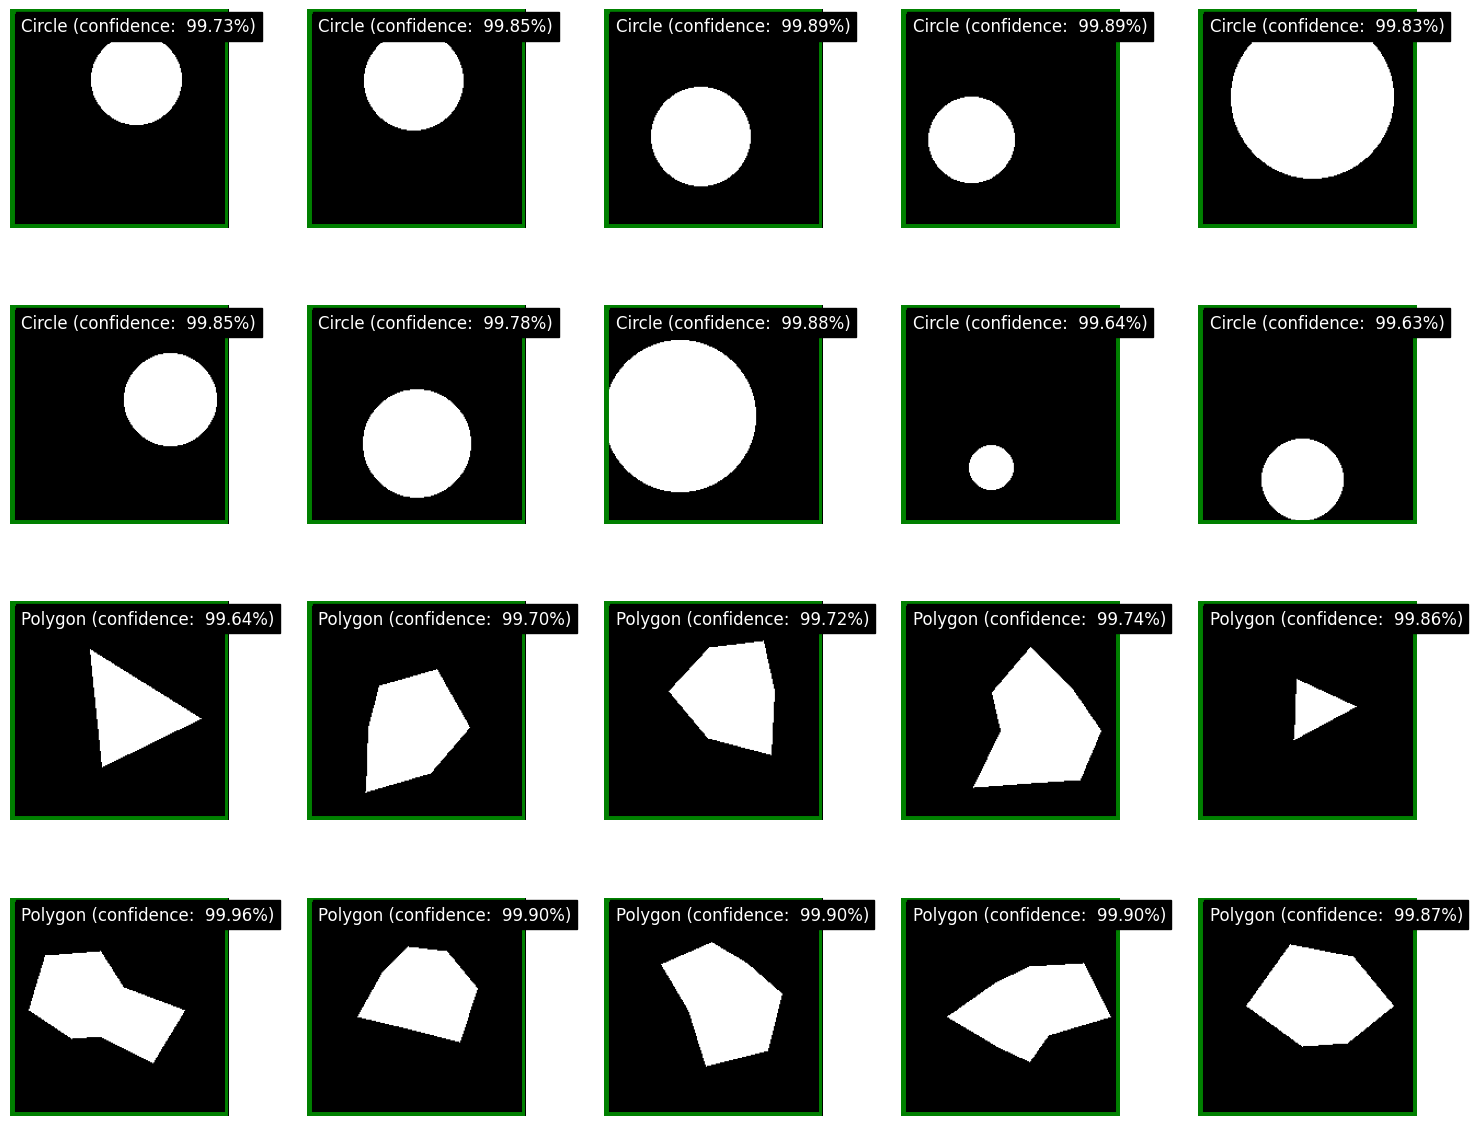

In [17]:
# Define the paths to the test images
test_images = validation_generator.filepaths[-20:]

# Initialize lists to store predictions and true labels
test_predictions = []
test_true_labels = validation_generator.classes[-20:]  # True labels for the last 20 images
test_raw_predictions = []

# Loop through each test image
for img_path in test_images:
    # Load and preprocess the image
    img = load_img(img_path, target_size=(200, 200), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    raw_prediction = model.predict(img_array)[0][0]  # Get raw prediction (probability)
    test_raw_predictions.append(raw_prediction)
    predicted_class = np.round(raw_prediction).astype(int)  # Convert to 0 or 1
    test_predictions.append(predicted_class)

# Plot the images with a red edge for incorrect predictions and green for correct
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i, (img_path, pred, true, raw_pred) in enumerate(zip(test_images, test_predictions, test_true_labels, test_raw_predictions)):
    # Load the image for plotting
    image = load_img(img_path, color_mode='grayscale')
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

    # Calculate confidence percentage
    confidence_percentage = raw_pred * 100 if pred == 1 else (1 - raw_pred) * 100
    prediction_label = "Circle" if pred == 0 else "Polygon"
    confidence_text = f"{prediction_label} (confidence:  {confidence_percentage:.2f}%)"

    # Display confidence text on the image
    axes[i].text(10, 20, confidence_text, color='white', fontsize=12, backgroundcolor='black')

    # Add a red or green rectangle based on prediction correctness
    if pred != true:
        rect = patches.Rectangle((0, 0), 199, 199, linewidth=5, edgecolor='red', facecolor='none')
    else:
        rect = patches.Rectangle((0, 0), 199, 199, linewidth=5, edgecolor='green', facecolor='none')

    axes[i].add_patch(rect)

plt.tight_layout()
plt.show()


 7. Creëer een nieuwe afbeelding van een regelmatige veelhoek

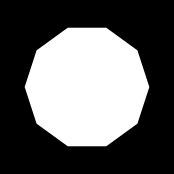

In [14]:
# Create a blank figure and axis
fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_aspect('equal')
ax.axis('off')  # Turn off the axis

# Set the background color to black
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Define the radius and center of the decagon
radius = 80
center = (100, 100)

# Compute the vertices of the regular polygon
angles = np.linspace(0, 2 * np.pi, 10, endpoint=False)
x = center[0] + radius * np.cos(angles)
y = center[1] + radius * np.sin(angles)

# Create a polygon patch (decagon)
decagon = patches.Polygon(np.column_stack([x, y]), closed=True, color='white')

# Add the decagon to the plot
ax.add_patch(decagon)

# Save the image with a black background (no transparency)
plt.gcf().savefig('afbeelding.png', dpi=100, bbox_inches='tight', pad_inches=0)

plt.show()


8. Test de nieuwe afbeelding

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


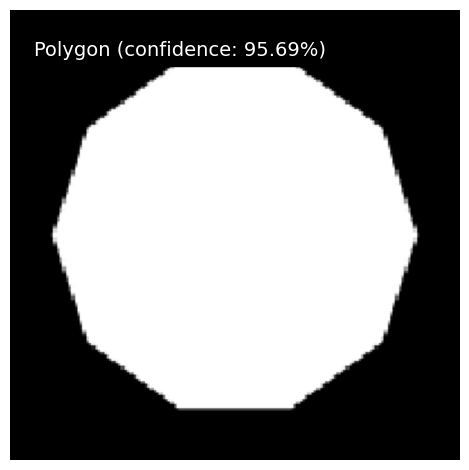

In [15]:
# Load and preprocess the image as grayscale
#img_path = 'Polygons/polygon_20.png'
img_path = 'afbeelding.png'

img = load_img(img_path, color_mode='grayscale', target_size=(200, 200))
img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make the prediction
prediction = model.predict(img_array)
predicted_class = np.round(prediction).astype(int).flatten()[0]

# Calculate confidence percentage
confidence_percentage = prediction[0][0] * 100 if predicted_class == 1 else (1 - prediction[0][0]) * 100

# Determine the prediction label
prediction_label = "Circle" if predicted_class == 0 else "Polygon"

# Plot the image with the prediction label and confidence percentage
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.axis('off')

# Display confidence and prediction text on the image
confidence_text = f"{prediction_label} (confidence: {confidence_percentage:.2f}%)"
plt.text(10, 20, confidence_text, color='white', fontsize=14, backgroundcolor='black')

plt.tight_layout()
plt.show()
